In [1]:
#imports

import warnings 
  
print('Hello') 
  
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 
import pandas as pd
import numpy as np
from itertools import combinations
import pickle
import time
import webbrowser

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_regression


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#load the dataframe----bikes
url = './data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)
bikes.columns=[col.lower().replace(" ","_") if col !='count' else 'total_rentals'for col in bikes.columns]
bikes.columns
bikes=bikes.drop(['atemp','registered', 'casual'],axis=1)
#feature engineering

bikes['hour']=bikes.index.hour
bikes['weekday']=bikes.index.day_name()
features=[col for col in bikes.columns if col !='total_rentals']

numerical_features=['temp','windspeed','humidity']

#feature engineering

bikes['hour']=bikes.index.hour
bikes['weekday']=bikes.index.day_name()
new_bikes=bikes.copy()
columns_to_dummify=['hour','weekday','season']
for col in columns_to_dummify:
    dummies=pd.get_dummies(bikes[col],prefix=col,drop_first=True)
    bikes=pd.concat([bikes,dummies],axis=1)
#bikes.drop(['weekday','hour'],axis=1,inplace=True)

#classifying features
cat_features=[col for col in features if col not in numerical_features]
alg_dict={'Linear Regression':LinearRegression(),
         'Random Forest': RandomForestRegressor(),
         'Ridge': Ridge(),
         'SVR':SVR()}
models=[('NN',MLPRegressor(max_iter=300,random_state=999)),
       ("boosting",GradientBoostingRegressor(random_state=999)),
        ("knn", KNeighborsRegressor()),
        ('SVR',LinearSVR())
       ]
final_models=[('NN',MLPRegressor(max_iter=600,random_state=999)),
               ('Random Forest',RandomForestRegressor())]
print('DOOOOOOOOONE')

Hello
DOOOOOOOOONE


In [2]:
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df.total_rentals
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred)),r2_score(y_test,y_pred)

def train_test_rmse_and_alg(df, feature_cols,algorithm):
    X = df[feature_cols]
    y = df.total_rentals
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=123)
    
    alg = algorithm
    alg.fit(X_train, y_train)
    
    y_pred = alg.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred)),r2_score(y_test,y_pred)
def train_test_rmse_and_ss(df, feature_cols,algorithm):
    X = df[feature_cols]
    y = df.total_rentals
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=123)
    
    ss=StandardScaler()
    
    X_s_train= ss.fit_transform(X_train)
    
    X_s_test=ss.transform(X_test)
    alg=algorithm
    
    alg.fit(X_s_train, y_train)
    
    y_pred = alg.predict(X_s_test)

    return np.sqrt(mean_squared_error(y_test, y_pred)),r2_score(y_test,y_pred)

In [ ]:
st = time.time()
results_df2=pd.DataFrame(columns=['features','rmse','r2','#features','algorithm'])
count=0
for i in range(1,len(features)+1):
    for combo in list(combinations(features, i)):
        combo_list=list(combo)
        #print(combo_list,type(combo_list))
        length=len(combo_list)        
        count+=1
        if count%50==0:
            print('COUNT',count)
        final_list=[]
            
        for feature in combo_list:
            #print(feature)
            if feature in columns_to_dummify:
                
                final_list.extend([col for col in bikes.columns if feature+'_' in col])
            else:
                final_list.append(feature)
                
        #print('FINAL LIST',final_list)
                        
        for algorithm in alg_dict.items():
            if algorithm[0] in ['Ridge','SVR'] and len(final_list)!=1:
                rmse,r2=train_test_rmse_and_ss(bikes, final_list,algorithm[1])
                results_df2.loc[len(results_df2.index)]= [final_list,rmse,r2,length,algorithm[0]]

            else:
                rmse,r2=train_test_rmse_and_alg(bikes, final_list,algorithm[1])
                results_df2.loc[len(results_df2.index)]= [final_list,rmse,r2,length,algorithm[0]]

et = time.time()
  

with open('resuts_df2.pkl','wb') as file:
    pickle.dump(results_df2,file)
f'It took that many minutes {round((et-st)/60,2)} to get it done'
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

# Analyzing Results

In [3]:
with open('resuts_df2.pkl','rb') as file:
    results= pickle.load(file)

In [4]:
#Best algorithm
results.groupby('algorithm').rmse.min().sort_values()
##E+RandomForest is a clear winner

algorithm
Random Forest         77.757430
Linear Regression    111.365339
Ridge                111.366592
SVR                  131.077315
Name: rmse, dtype: float64

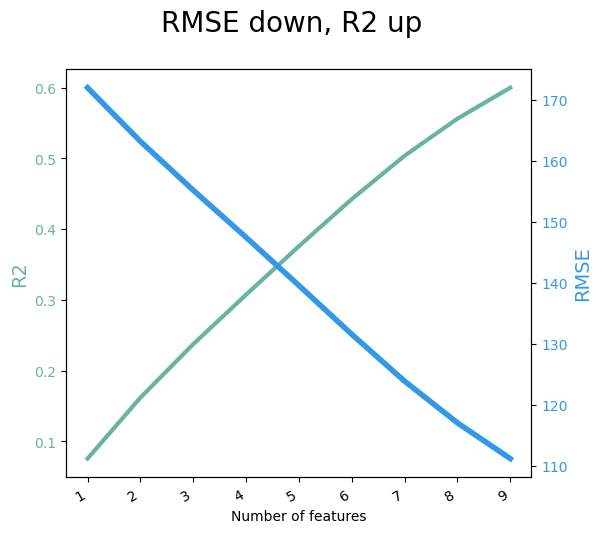

In [5]:
groupy=results.groupby('#features')[['rmse','r2']].mean()
COLOR_R2 = "#69b3a2"
COLOR_RMSE = "#3399e6"

fig, ax1 = plt.subplots(figsize=(6, 6))
ax2 = ax1.twinx()

ax1.plot(groupy.index, groupy.r2, color=COLOR_R2, lw=3)
ax2.plot(groupy.index, groupy.rmse, color=COLOR_RMSE, lw=4)

ax1.set_xlabel("Number of features")
ax1.set_ylabel("R2", color=COLOR_R2, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_R2)

ax2.set_ylabel("RMSE", color=COLOR_RMSE, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_RMSE)

fig.suptitle("RMSE down, R2 up", fontsize=20)
fig.autofmt_xdate()
#Obvoiously, to select all features seems the best option

In [6]:
results.sort_values('rmse').groupby('algorithm').first()
#Except for SVR all get the best results with alomst all features

,features,rmse,r2,#features
algorithm,,,,
Linear Regression,"[season_2, season_3, season_4, holiday, workin...",111.365339,0.615418,9
Random Forest,"[season_2, season_3, season_4, workingday, wea...",77.757430,0.812512,8
Ridge,"[season_2, season_3, season_4, workingday, wea...",111.366592,0.615410,8
SVR,"[workingday, temp, humidity, hour_1, hour_2, h...",131.077315,0.467225,4


In [7]:
#Finally, just confirming our results, will anayze the score in RandomForest based on features
results[results['algorithm']=='Random Forest'].groupby('#features')[['rmse','r2']].mean()

,rmse,r2
#features,,
1,170.163766,0.094589
2,160.545461,0.185425
3,152.031901,0.261307
4,142.530123,0.341068
5,130.336917,0.438880
6,115.878161,0.549882
7,101.081385,0.657606
8,88.196721,0.745721
9,77.843049,0.812099


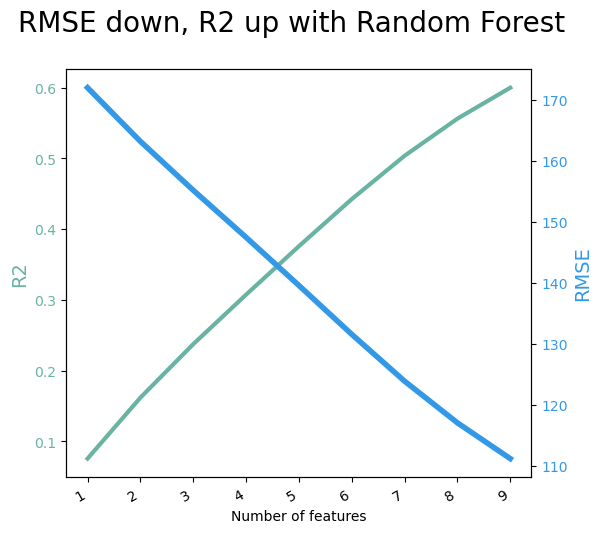

In [8]:
groupy_rf=results[results['algorithm']=='Random Forest'].groupby('#features')[['rmse','r2']].mean()

COLOR_R2 = "#69b3a2"
COLOR_RMSE = "#3399e6"

fig, ax1 = plt.subplots(figsize=(6, 6))
ax2 = ax1.twinx()

ax1.plot(groupy_rf.index, groupy.r2, color=COLOR_R2, lw=3)
ax2.plot(groupy_rf.index, groupy.rmse, color=COLOR_RMSE, lw=4)

ax1.set_xlabel("Number of features")
ax1.set_ylabel("R2", color=COLOR_R2, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_R2)

ax2.set_ylabel("RMSE", color=COLOR_RMSE, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_RMSE)

fig.suptitle("RMSE down, R2 up with Random Forest", fontsize=20)
fig.autofmt_xdate()
#Obvoiously, to select all features seems the best option

In [9]:
#Curiosity what feature/s are left out in the best solution for LinearRegression and Ridge
for algorithm in alg_dict.keys():
    rmse_min=results[results['algorithm']==algorithm]['rmse'].min()
    list_fea=results[(results['algorithm']==algorithm)&(results['rmse']==rmse_min)]['features'].values[0]
    print(algorithm,rmse_min,[col for col in list_fea if '_' not in col and col not in features])

Linear Regression 111.36533876817826 []
Random Forest 77.75742950775866 []
Ridge 111.36659207283859 []
SVR 131.07731477960593 []


# Using Pipeline, crossvalidation and SelectKbest to try new models

In [34]:
st = time.time()
results_df=pd.DataFrame(columns=['features','rmse_ytest','rmse_cv','#features','algorithm'])
new_features=[col for col in new_bikes.columns if col !='total_rentals']
numerical_features=['temp','windspeed','humidity']
categorical_features=[col for col in new_features if col not in numerical_features]

count=0

                        
for model in models:
    X=new_bikes[new_features]
    y=new_bikes.total_rentals

    X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=999)

    steps=[('columns',ColumnTransformer(
            transformers=[("cat", OneHotEncoder(categories='auto',sparse_output=False,handle_unknown='ignore'), categorical_features)],
            remainder="passthrough",
            )),
          ('standardization',StandardScaler()),
          ('regressor',model[1])]

    pipeline=Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    y_preds=pipeline.predict(X_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_preds))
    cv=KFold()
    scores=cross_val_score(pipeline,X_train,y_train,cv=cv,scoring='neg_mean_squared_error')
    results_df.loc[len(results_df.index)]= [new_features,rmse,np.sqrt(np.abs(scores)).mean(),\
                                            len(new_features),model[0]]

et = time.time()


with open('resuts_df_plus.pkl','wb') as file:
    pickle.dump(results_df,file)
print(f'It took that many minutes {round((et-st)/60,2)} to get it done')
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

It took that many minutes 1.19 to get it done


True

In [10]:

with open('resuts_df_plus.pkl','rb') as file:
    results=pickle.load(file)
results

,features,rmse_ytest,rmse_cv,#features,algorithm
0,"[season, holiday, workingday, weather, temp, h...",70.719775,73.097572,9,NN
1,"[season, holiday, workingday, weather, temp, h...",92.466876,93.979924,9,boosting
2,"[season, holiday, workingday, weather, temp, h...",88.903196,89.084960,9,knn
3,"[season, holiday, workingday, weather, temp, h...",110.514151,113.750413,9,SVR


# from now on, I will only work with rf and NN.
# I will try using selectKbest just to confirm the right number of features

In [35]:
new_features=[col for col in new_bikes.columns if col !='total_rentals']
results_df=pd.DataFrame(columns=['features','rmse_cv','rmse_y_test','#features','algorithm'])
#num_features=15

X=new_bikes[new_features]
y=new_bikes.total_rentals

X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=999)

for num_features in range(44,0,-10):
    

    for model in final_models:

        steps=[('columns',ColumnTransformer(
                transformers=[("cat", OneHotEncoder(categories='auto',sparse_output=False,handle_unknown='ignore'), [0,3,7,8])],
                remainder="passthrough",
            )),
               ('feature_selection', SelectKBest(f_regression,k=num_features)),
              ('standardization',MinMaxScaler()),
              ('regressor',model[1])]

        pipe=Pipeline(steps=steps)
        pipe.fit(X_train,y_train)
        mask=pipe.named_steps['feature_selection'].get_support()
        column_names=pipe.named_steps['columns'].get_feature_names_out()
        selection=[''.join(a.split('__')[1]) for a,b in zip(column_names,mask) if b]
        print(num_features,len(mask),len(selection))
        y_preds=pipe.predict(X_test)
        rmse=np.sqrt(mean_squared_error(y_test,y_preds))
        cv=KFold(n_splits=3)
        scores=cross_val_score(pipe,X_train,y_train,cv=cv,scoring='neg_mean_squared_error')
        results_df.loc[len(results_df.index)] = [selection,np.sqrt(np.abs(scores).mean()),rmse,len(selection) , model[0]]
        
with open('results_nn_rf.pkl','wb') as f:
    pickle.dump(results_df,f)
print('DONE')

44 44 44
44 44 44
34 44 34
34 44 34
24 44 24
24 44 24
14 44 14
14 44 14
4 44 4
4 44 4
DONE


In [8]:
with open('results_nn_rf.pkl','rb') as f:
    results=pickle.load(f)
results.groupby('#features')['rmse_y_test'].min()

#features
4     136.934974
14    110.364717
24    102.836068
34     92.396533
44     75.197869
Name: rmse_y_test, dtype: float64

In [10]:
results.sort_values('rmse_y_test')

,features,rmse_cv,rmse_y_test,#features,algorithm
0,"[season_1, season_2, season_3, season_4, weath...",NaN,75.197869,44,NN
1,"[season_1, season_2, season_3, season_4, weath...",NaN,75.337740,44,Random Forest
2,"[season_1, season_2, season_3, season_4, weath...",93.959830,92.396533,34,NN
3,"[season_1, season_2, season_3, season_4, weath...",93.845283,94.699846,34,Random Forest
4,"[season_1, season_2, season_3, weather_1, weat...",106.392060,102.836068,24,NN
5,"[season_1, season_2, season_3, weather_1, weat...",109.717373,106.358917,24,Random Forest
6,"[season_1, hour_0, hour_1, hour_2, hour_3, hou...",113.357845,110.364717,14,NN
7,"[season_1, hour_0, hour_1, hour_2, hour_3, hou...",119.779605,119.374670,14,Random Forest
8,"[hour_17, hour_18, temp, humidity]",142.391154,136.934974,4,NN
9,"[hour_17, hour_18, temp, humidity]",146.602553,143.274448,4,Random Forest


# Tuning the model and analyzing the most relevant features

## RF

In [11]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid_pipe = {'regressor__n_estimators': n_estimators,
               'regressor__max_features': max_features,
               'regressor__max_depth': max_depth,
               'regressor__min_samples_split': min_samples_split,
               'regressor__min_samples_leaf': min_samples_leaf,
               'regressor__bootstrap': bootstrap}
random_grid_pipe

{'regressor__n_estimators': [200,
  400,
  600,
  800,
  1000,
  1200,
  1400,
  1600,
  1800,
  2000],
 'regressor__max_features': ['log2', 'sqrt'],
 'regressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'regressor__min_samples_split': [2, 5, 10],
 'regressor__min_samples_leaf': [1, 2, 4],
 'regressor__bootstrap': [True, False]}

In [36]:
new_features=[col for col in new_bikes.columns if col !='total_rentals']

X=new_bikes[new_features]
y=new_bikes.total_rentals

X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=999)

steps=[('columns',ColumnTransformer(
                transformers=[("cat", OneHotEncoder(categories='auto',sparse_output=False,handle_unknown='ignore'), [0,3,7,8])],
                remainder="passthrough",
            )),
              ('standardization',MinMaxScaler()),
              ('regressor',RandomForestRegressor())]

final_pipe=Pipeline(steps=steps)


rf_random = RandomizedSearchCV(estimator = final_pipe, param_distributions = random_grid_pipe, 
                               n_iter = 100, cv = 3, verbose=0, random_state=42, 
                               n_jobs = -1)

best_model=rf_random.fit(X_train,y_train)
preds=best_model.predict(X_test)
np.sqrt(mean_squared_error(y_test,preds))
print("Done")

Done


In [13]:
best_params=best_model.best_params_
final_params={k.split('__')[1]: v for k,v in best_params.items()}
final_params

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [14]:
new_features=[col for col in new_bikes.columns if col !='total_rentals']

X=new_bikes[new_features]
y=new_bikes.total_rentals

X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=999)

steps=[('columns',ColumnTransformer(
                transformers=[("cat", OneHotEncoder(categories='auto',sparse_output=False,handle_unknown='ignore'), [0,3,7,8])],
                remainder="passthrough",
            )),
              ('standardization',MinMaxScaler()),
              ('regressor',RandomForestRegressor(**final_params))]

final_pipe=Pipeline(steps=steps)
final_pipe.fit(X_train,y_train)
preds=final_pipe.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,preds))
rmse

75.08994530904484

In [15]:
features_importances=final_pipe[-1].feature_importances_
features_names=final_pipe[0].get_feature_names_out()

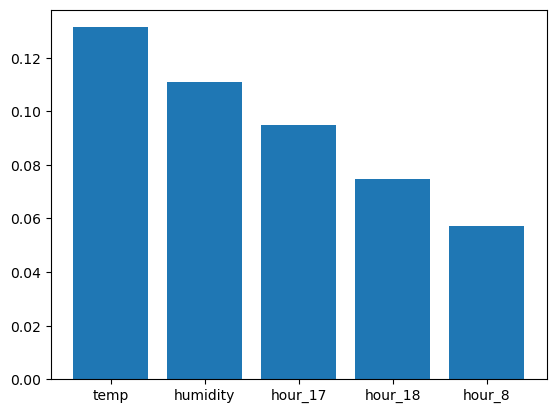

In [17]:
names_importances=[(a.split("__")[1],b) for a,b in zip(features_names,features_importances)]
best_features=sorted(names_importances,key=lambda x: x[1], reverse=True)[:5]
best_names=[x[0] for x in best_features]
best_importances=[x[1] for x in best_features]
plt.bar(best_names,best_importances);

## NN

In [ ]:
new_features=[col for col in new_bikes.columns if col !='total_rentals']
param_grid = {
    'regressor__hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'regressor__max_iter': [50, 100,400, 700],
    'regressor__activation': ['tanh', 'relu'],
    'regressor__solver': ['sgd', 'adam'],
    'regressor__alpha': [0.0001, 0.05],
    'regressor__learning_rate': ['constant','adaptive'],
}

X=new_bikes[new_features]
y=new_bikes.total_rentals

X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=999)

steps=[('columns',ColumnTransformer(
                transformers=[("cat", OneHotEncoder(categories='auto',sparse_output=False,handle_unknown='ignore'), [0,3,7,8])],
                remainder="passthrough",
            )),
              ('standardization',MinMaxScaler()),
              ('regressor',MLPRegressor(max_iter=600,random_state=999))]

final_pipe=Pipeline(steps=steps)


grid = GridSearchCV(final_pipe, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_) 


grid_predictions = grid.predict(X_test)
print('RMSE: ',np.sqrt(mean_squared_error(y_test,grid_predictions)))
print('R2: ',r2_score(y_test,grid_predictions))
print("Done")
grid.best_params_

In [ ]:
{'regressor__activation': 'relu', 'regressor__alpha': 0.0001, 'regressor__hidden_layer_sizes': (120, 80, 40), 'regressor__learning_rate': 'constant', 'regressor__max_iter': 100, 'regressor__solver': 'adam'}
RMSE:  71.74701953565547
R2:  0.8401473439916183
Done
{'regressor__activation': 'relu',
 'regressor__alpha': 0.0001,
 'regressor__hidden_layer_sizes': (120, 80, 40),
 'regressor__learning_rate': 'constant',
 'regressor__max_iter': 100,
 'regressor__solver': 'adam'}